In [11]:
import pandas as pd
import numpy as np

# Data Preprocessing and Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the cleaned datasets
race_results = pd.read_csv('cleaned_race_results.csv')
race_details = pd.read_csv('cleaned_race_details.csv')

# Convert 'race_date' to datetime in both datasets
race_results['race_date'] = pd.to_datetime(race_results['race_date'], format='%Y-%m-%d')
race_details['race_date'] = pd.to_datetime(race_details['race_date'], format='%Y-%m-%d')

# Standardize 'race_city' to lowercase and strip whitespace
race_results['race_city'] = race_results['race_city'].str.lower().str.strip()
race_details['race_city'] = race_details['race_city'].str.lower().str.strip()

# Merge datasets on 'race_date', 'race_city', and 'race_no'
merged_df = pd.merge(race_results, race_details, on=['race_date', 'race_city', 'race_no'], how='left')

# Verify the merge
print(f"Merged Data Shape: {merged_df.shape}")
print(merged_df.head())


Merged Data Shape: (4206, 29)
   race_date race_city  race_no  result      horse_name horse_accessories  \
0 2024-01-01     bursa        1       1      MY REVERIE           KG K DB   
1 2024-01-01     bursa        1       2     NOBLE WOMAN          KG DB SK   
2 2024-01-01     bursa        1       3    ÇİSEM SULTAN      KG K DB SGKR   
3 2024-01-01     bursa        1       4  OKYANUS GÜZELİ            SKG SK   
4 2024-01-01     bursa        1       5   MOUNTAIN LION             DB SK   

   horse_age horse_sex                                       horse_origin  \
0          3         f  BLUEGRASS CAT (USA)- LEGALLY INCLUDED (USA) / ...   
1          3         f             SCARFACE- PROVIDENCE / SRI PEKAN (USA)   
2          3         f  SMART ROBIN (JPN)- SNOOZY TIMES / ROYAL ABJAR ...   
3          3         f           SIDNEY'S CANDY (USA)- NURSENA / SCARFACE   
4          3         m     LION HEART (USA)- SAN MARINO / SRI PEKAN (USA)   

             horse_sire  ... horse_race_degr

In [13]:
# Define string columns to standardize
string_cols = [
    'horse_sex', 'race_type', 'race_track_condition', 'race_track_type',
    'jockey_name', 'horse_sire', 'horse_dam', 'horse_trainer', 'race_city'
]

# Apply standardization
for col in string_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].str.lower().str.strip()

In [14]:
# Define 'is_top3' as 1 if result <= 3, else 0
merged_df['is_top3'] = merged_df['result'].apply(lambda x: 1 if x <= 3 else 0)

# Verify the new target
print(merged_df[['result', 'is_top3']].head())
print(merged_df['is_top3'].value_counts())


   result  is_top3
0       1        1
1       2        1
2       3        1
3       4        0
4       5        0
is_top3
0    2774
1    1432
Name: count, dtype: int64


In [15]:
merged_df.head()

,race_date,race_city,race_no,result,horse_name,horse_accessories,horse_age,horse_sex,horse_origin,horse_sire,...,race_type,race_sex_group,race_age_group,race_race_group,race_length,race_track_type,race_track_condition,best_rating,best_rating_seconds,is_top3
0,2024-01-01,bursa,1,1,MY REVERIE,KG K DB,3,f,BLUEGRASS CAT (USA)- LEGALLY INCLUDED (USA) / ...,bluegrass cat (usa),...,condition 2,undefined,3 years old,english,1400,dirt,good going,1.24.50,84.5,1
1,2024-01-01,bursa,1,2,NOBLE WOMAN,KG DB SK,3,f,SCARFACE- PROVIDENCE / SRI PEKAN (USA),scarface,...,condition 2,undefined,3 years old,english,1400,dirt,good going,1.24.50,84.5,1
2,2024-01-01,bursa,1,3,ÇİSEM SULTAN,KG K DB SGKR,3,f,SMART ROBIN (JPN)- SNOOZY TIMES / ROYAL ABJAR ...,smart robin (jpn),...,condition 2,undefined,3 years old,english,1400,dirt,good going,1.24.50,84.5,1
3,2024-01-01,bursa,1,4,OKYANUS GÜZELİ,SKG SK,3,f,SIDNEY'S CANDY (USA)- NURSENA / SCARFACE,sidney's candy (usa),...,condition 2,undefined,3 years old,english,1400,dirt,good going,1.24.50,84.5,0
4,2024-01-01,bursa,1,5,MOUNTAIN LION,DB SK,3,m,LION HEART (USA)- SAN MARINO / SRI PEKAN (USA),lion heart (usa),...,condition 2,undefined,3 years old,english,1400,dirt,good going,1.24.50,84.5,0


In [16]:
# Define initial feature set
initial_features = [
    #'race_date',
    'horse_age',
    'horse_sex',
    #'horse_origin',
    'jockey_weight',
    'race_length',
    'race_type',
    'race_track_condition',
    'race_track_type',
    'horse_win_value',
    'horse_rate',
    #'horse_race_degree_seconds'
]

# Create feature matrix X and target vector y
X = merged_df[initial_features]
y = merged_df['is_top3']

### Select Categorical and Numerical Features

In [17]:
# Identify categorical and numerical features
categorical_features = ['horse_sex', 'race_type', 'race_track_condition', 'race_track_type']
numerical_features = ['horse_age', 'jockey_weight', 'race_length', 'horse_win_value', 'horse_rate']

### Encode Categorical Features Using One-Hot Encoding

In [23]:
# Define the ColumnTransformer for encoding without dropping the first category
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep the numerical features as they are
)

# Apply the preprocessor to X
X_encoded = preprocessor.fit_transform(X)

# Get feature names after encoding
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_features) + numerical_features

# Check the shape of X_encoded and all_feature_names
print(f"Shape of X_encoded: {X_encoded.shape}")
print(f"Number of all_feature_names: {len(all_feature_names)}")

Shape of X_encoded: (4206, 33)
Number of all_feature_names: 33


In [19]:
# Check unique categories for each categorical feature
for col in categorical_features:
    unique_vals = merged_df[col].nunique()
    unique_categories = merged_df[col].unique()
    print(f"'{col}' has {unique_vals} unique categories.")
    print(f"Unique categories in '{col}': {unique_categories}")
    print("-" * 50)


'horse_sex' has 2 unique categories.
Unique categories in 'horse_sex': ['f' 'm']
--------------------------------------------------
'race_type' has 20 unique categories.
Unique categories in 'race_type': ['condition 2' 'maiden' 'condition 3' 'condition 4' 'handicap 15'
 'condition-6' 'handicap 14' 'condition 5' 'handicap 21' 'handicap 13'
 'handicap 17' 'handicap 16' 'sale 1' 'condition-8' 'g 3' 'condition-9'
 'condition 1' 'sale 3' 'sale 2' 'condition-7']
--------------------------------------------------
'race_track_condition' has 4 unique categories.
Unique categories in 'race_track_condition': ['good going' 'muddy' 'moist' 'wet']
--------------------------------------------------
'race_track_type' has 2 unique categories.
Unique categories in 'race_track_type': ['dirt' 'dirt (polytrack)']
--------------------------------------------------


## Prepare the Model DataFrame

In [24]:
# Convert to DataFrame for easier handling
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=all_feature_names, index=X.index)

# Combine with the target variable
model_df = pd.concat([X_encoded_df, y], axis=1)

# Verify the feature set
print(f"Model Data Shape: {model_df.shape}")
print(model_df.head())

Model Data Shape: (4206, 34)
   horse_sex_f  horse_sex_m  race_type_condition 1  race_type_condition 2  \
0          1.0          0.0                    0.0                    1.0   
1          1.0          0.0                    0.0                    1.0   
2          1.0          0.0                    0.0                    1.0   
3          1.0          0.0                    0.0                    1.0   
4          0.0          1.0                    0.0                    1.0   

   race_type_condition 3  race_type_condition 4  race_type_condition 5  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   race_type_condition-6  race_type_condition-7  race_type_cond

## Temporal Data Splitting

In [28]:
# Sort the dataset by 'race_date' to maintain temporal order
model_df = merged_df.sort_values('race_date').reset_index(drop=True)

# Add the encoded features back to model_df if not already
model_df = pd.concat([X_encoded_df, y], axis=1)

# Define the split date (e.g., June 1, 2024)
split_date = pd.to_datetime('2024-01-27')

# Extract the race_date for splitting
race_dates = merged_df.sort_values('race_date').reset_index(drop=True)['race_date']

# Split the data into training and testing sets based on the split date
train_df = model_df[race_dates < split_date]
test_df = model_df[race_dates >= split_date]

# Define feature matrices and target vectors
X_train = train_df.drop(['is_top3'], axis=1)
y_train = train_df['is_top3']
X_test = test_df.drop(['is_top3'], axis=1)
y_test = test_df['is_top3']

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")


Training Set Shape: (3421, 33)
Testing Set Shape: (785, 33)


In [29]:
# Check class distribution
print("Class Distribution in Training Set:")
print(y_train.value_counts())

print("\nClass Distribution in Testing Set:")
print(y_test.value_counts())


Class Distribution in Training Set:
is_top3
0    2239
1    1182
Name: count, dtype: int64

Class Distribution in Testing Set:
is_top3
0    535
1    250
Name: count, dtype: int64


## Random Forest Classifier with Class Weight Adjustment


Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       535
           1       0.64      0.44      0.52       250

    accuracy                           0.74       785
   macro avg       0.71      0.66      0.67       785
weighted avg       0.73      0.74      0.73       785

Confusion Matrix:
[[473  62]
 [139 111]]
Accuracy: 0.7439
AUC Score: 0.7550


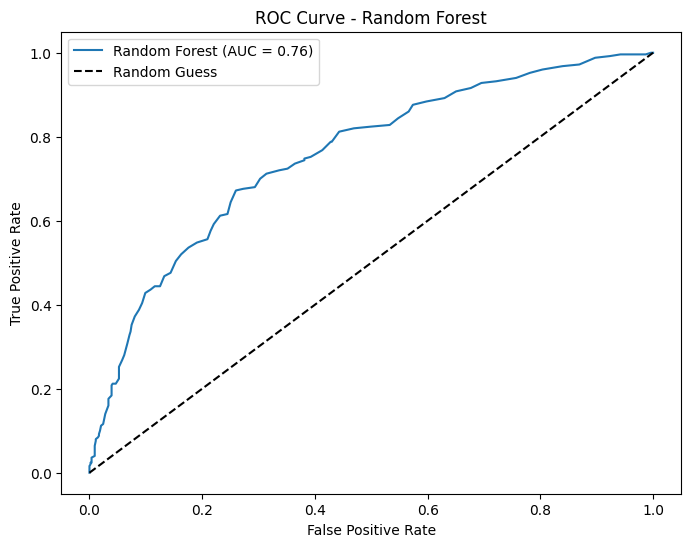

In [30]:
# Initialize the Random Forest Classifier with balanced class weights
rf_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:,1]

# Evaluate the model
print("\nRandom Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


In [31]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")

# Best estimator
best_rf = grid_search_rf.best_estimator_

# Make predictions with the best estimator
y_pred_best_rf = best_rf.predict(X_test)
y_prob_best_rf = best_rf.predict_proba(X_test)[:,1]

# Evaluate
print("\nBest Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_best_rf):.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Best Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       535
           1       0.60      0.60      0.60       250

    accuracy                           0.74       785
   macro avg       0.71      0.71      0.71       785
weighted avg       0.74      0.74      0.74       785

Confusion Matrix:
[[434 101]
 [100 150]]
Accuracy: 0.7439
AUC Score: 0.7915


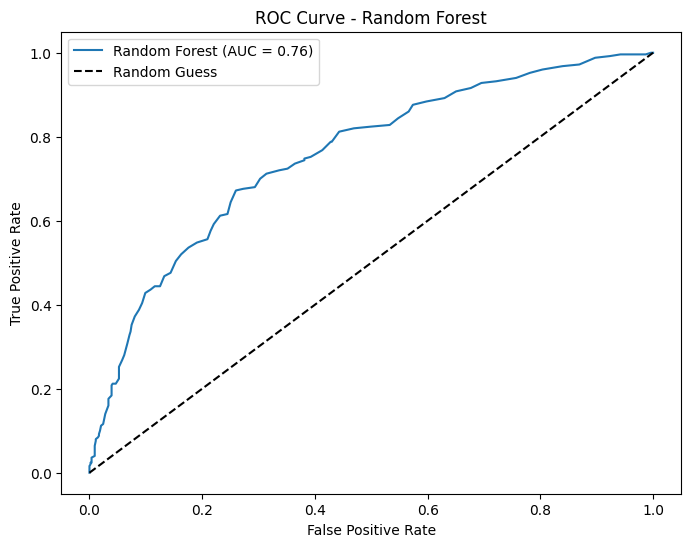

In [32]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

### Feature Importance Analysis


Top 10 Feature Importances (Random Forest):
horse_win_value                     0.384018
horse_rate                          0.196931
jockey_weight                       0.107024
race_length                         0.081603
horse_age                           0.065681
race_track_condition_good going     0.012188
race_track_type_dirt                0.011349
horse_sex_f                         0.011345
race_track_type_dirt (polytrack)    0.010707
horse_sex_m                         0.010466
dtype: float64


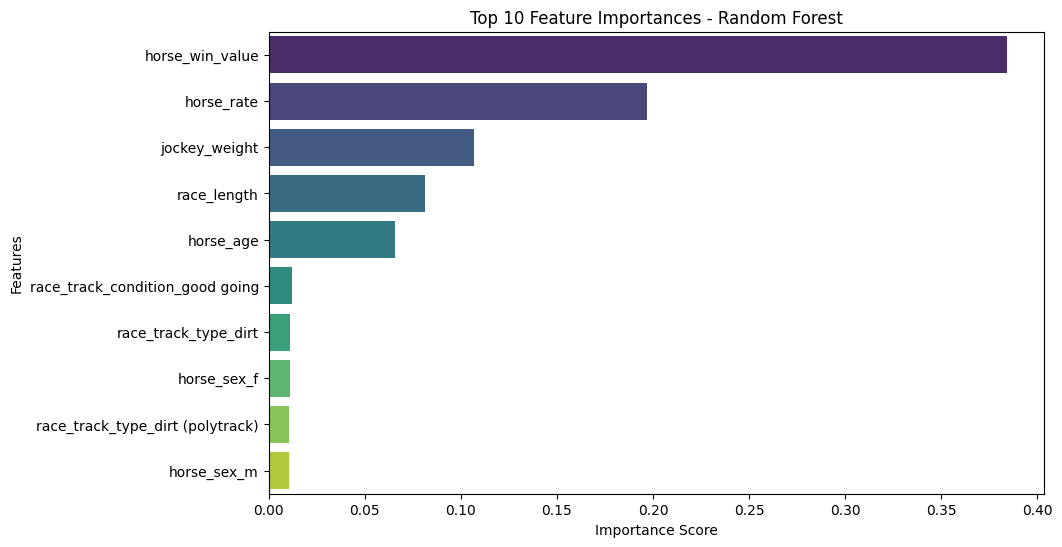

In [33]:
# Feature Importance for Random Forest
importances_rf = rf_clf.feature_importances_
feature_names_rf = X_train.columns
feature_importances_rf = pd.Series(importances_rf, index=feature_names_rf).sort_values(ascending=False)

# Display top 10 features
print("\nTop 10 Feature Importances (Random Forest):")
print(feature_importances_rf.head(10))

# Plot Feature Importances
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances_rf.head(10), y=feature_importances_rf.head(10).index, palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


## MLP Classifier with Class Weight Adjustment


MLP Classifier Performance:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       535
           1       0.00      0.00      0.00       250

    accuracy                           0.68       785
   macro avg       0.34      0.50      0.41       785
weighted avg       0.46      0.68      0.55       785

Confusion Matrix:
[[535   0]
 [250   0]]
Accuracy: 0.6815
AUC Score: 0.7730


c:\Users\pierr\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


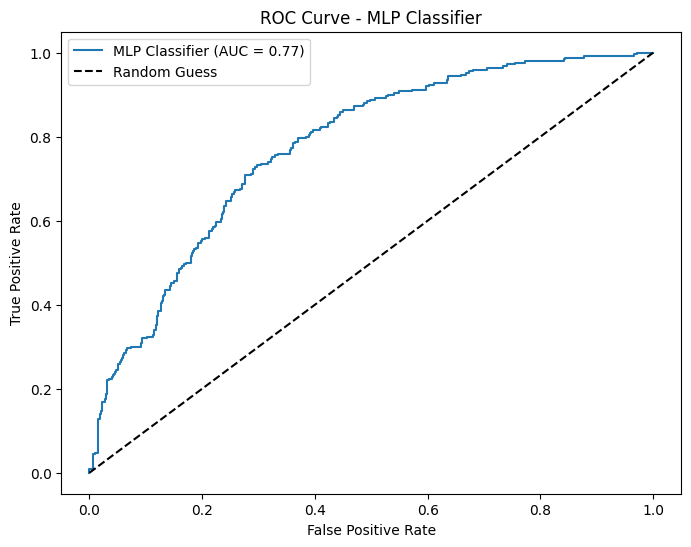

In [35]:
# Define parameter grid for MLP Classifier
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# Initialize GridSearchCV for MLP Classifier
mlp_clf = MLPClassifier(random_state=42, max_iter=300)
grid_search_mlp = GridSearchCV(
    estimator=mlp_clf,
    param_grid=param_grid_mlp,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV for MLP
grid_search_mlp.fit(X_train, y_train)

# Best parameters for MLP
#print(f"Best Parameters for MLP Classifier: {grid_search_mlp.best_params_}")

# Best estimator for MLP
best_mlp = grid_search_mlp.best_estimator_

# Make predictions with the best MLP estimator
y_pred_best_mlp = best_mlp.predict(X_test)
y_prob_best_mlp = best_mlp.predict_proba(X_test)[:, 1]

# Evaluate MLP Classifier
print("\nBest MLP Classifier Performance:")
print(classification_report(y_test, y_pred_best_mlp))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_mlp))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_mlp):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_best_mlp):.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_mlp)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'MLP Classifier (AUC = {roc_auc_score(y_test, y_prob_best_mlp):.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Classifier')
plt.legend()
plt.show()

## Gradient Boosting Classifier (e.g., XGBoost)

c:\Users\pierr\anaconda3\envs\datascience\lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       535
           1       0.56      0.58      0.57       250

    accuracy                           0.72       785
   macro avg       0.68      0.69      0.68       785
weighted avg       0.73      0.72      0.72       785

Confusion Matrix:
[[421 114]
 [104 146]]
Accuracy: 0.7223
AUC Score: 0.7562


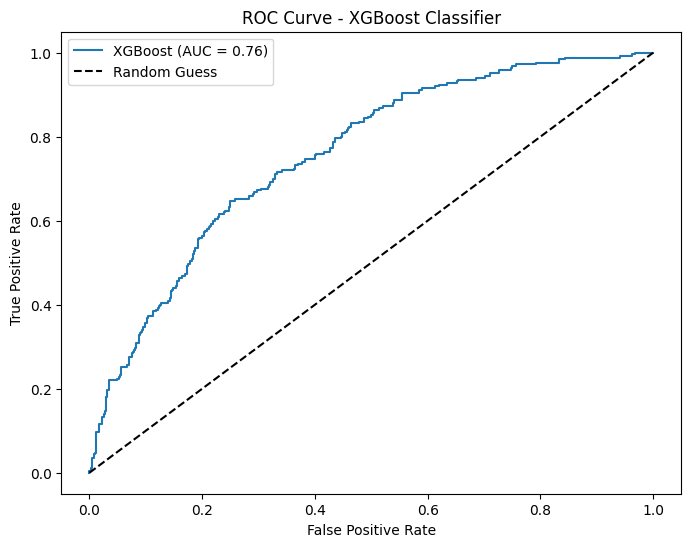

In [36]:
# !pip install xgboost

import xgboost as xgb

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV for XGBoost
xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV for XGBoost
grid_search_xgb.fit(X_train, y_train)

# Best parameters for XGBoost
#print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")

# Best estimator for XGBoost
best_xgb = grid_search_xgb.best_estimator_

# Make predictions with the best XGBoost estimator
y_pred_best_xgb = best_xgb.predict(X_test)
y_prob_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate XGBoost Classifier
print("\nBest XGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_best_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_best_xgb):.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_best_xgb):.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend()
plt.show()

## Ensemble Methods

In [38]:
from sklearn.ensemble import VotingClassifier

# Initialize individual classifiers
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), use_label_encoder=False, eval_metric='logloss', random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# Initialize Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('mlp', mlp_clf)],
    voting='soft'
)

# Train the ensemble
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)
y_prob_voting = voting_clf.predict_proba(X_test)[:,1]

# Evaluate the ensemble
print("\nVoting Classifier Performance:")
print(classification_report(y_test, y_pred_voting))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_voting):.4f}")


c:\Users\pierr\anaconda3\envs\datascience\lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Performance:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       535
           1       0.67      0.34      0.45       250

    accuracy                           0.74       785
   macro avg       0.71      0.63      0.64       785
weighted avg       0.72      0.74      0.71       785

Confusion Matrix:
[[492  43]
 [164  86]]
Accuracy: 0.7363
AUC Score: 0.7735
